In [2]:
import numpy as np
import os, sys

# --- Add parent directory ('lectures/#4/sims/') to path to find 'src' ---
notebook_dir = os.getcwd() # Should be 'lectures/#4/sims/step_1'
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..')) # Go up to 'lectures/#4/sims/'
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from src.pendulum import Pendulum
from src.controller import EnergyControl
from src.simulation import Simulation

Energy controller created with max_torque=0.1


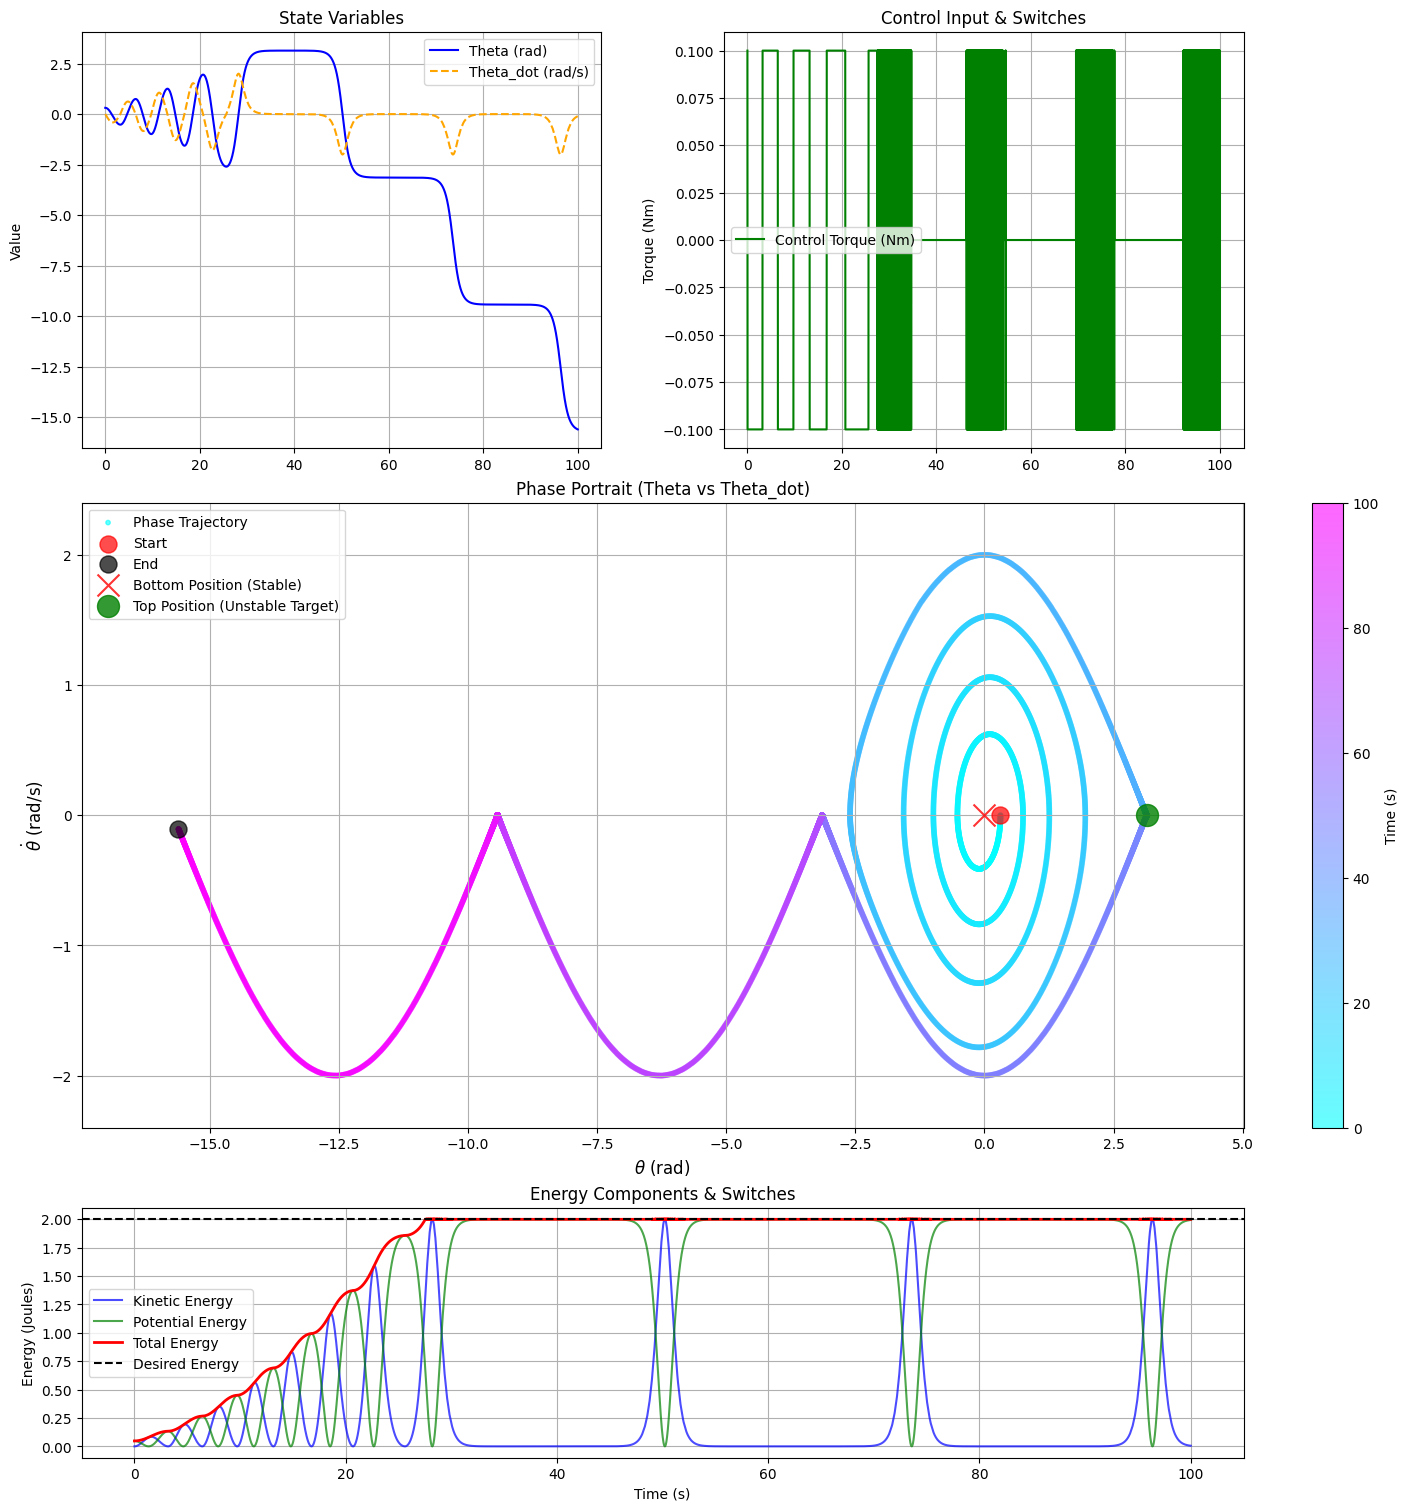

In [3]:
# 1. Create the system (Pendulum)
pendulum = Pendulum(
    mass=1.0,          # Mass of the pendulum bob (kg)
    length=1.0,        # Length of the pendulum rod (m)
    gravity=1,      # Acceleration due to gravity (m/s^2)
    damping=0.0,
    initial_state=np.array([0.31, 0.0]) # Initial state [angle (rad), angular_velocity (rad/s)]
                                       # Starts near the bottom equilibrium, with zero initial velocity.
)
# 2. Create the controller (Energy Control)
controller = EnergyControl(
    max_torque=.1   # Maximum allowed control torque (tau_bar) (Nm)
)
print(f"Energy controller created with max_torque={controller.max_torque}")

# 3. Create the simulation instance with direct time parameters
simulation = Simulation(
    system=pendulum,     # The pendulum system object created above
    controller=controller, # The energy controller object created above
    dt=0.01,             # Simulation time step (s) - passed directly
    num_steps=10000       # Total number of simulation steps - passed directly (equivalent to 30s / 0.01s)
)
simulation.run()
simulation.plot_results(save_fig=True, fig_name='img/energy_control.png') 

In [7]:
from src.plotter import Plotter
from src.pendulum import Pendulum
from src.controller import LinearFeedbackController
import matplotlib.pyplot as plt


Running 100 simulations...


Overall Progress: 100%|██████████| 100/100 [00:00<00:00, 292.76it/s]


100 simulations finished.
Eigenvalues: [-1. -1.]
Plotting phase portraits...
Plotting 100 trajectories...


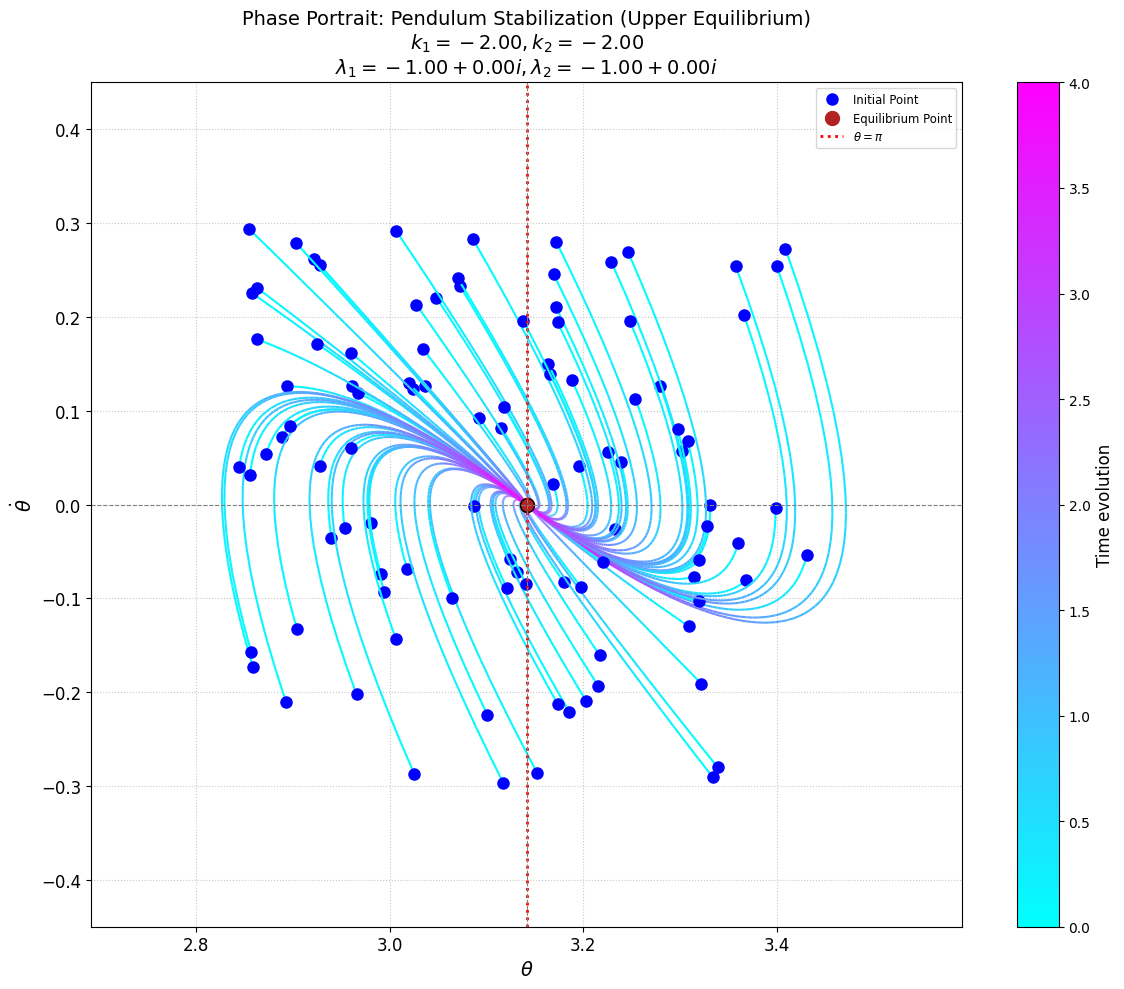

Script finished.


In [8]:
# --- Simulation Parameters ---
PEDULUM_MASS = 1.0  # kg
PEDULUM_LENGTH = 1.0  # m
GRAVITY = 1.0       # m/s^2 (Set to 1 to match linearization analysis)

TARGET_STATE = np.array([np.pi, 0.0]) # Target: Upper equilibrium (theta=pi, theta_dot=0)
K1 = -2.0 # Feedback gain for position error (Torque)
K2 = -2.0 # Feedback gain for velocity error (Torque)

DT = 0.05            # Simulation time step (s)
SIMULATION_TIME = 4 # Total simulation time (s)
NUM_STEPS = int(SIMULATION_TIME / DT)

NUM_TRAJECTORIES = 100
# Define range for random initial states around the target
INITIAL_STATE_RANGE_THETA = 0.3 # +/- this value around target theta
INITIAL_STATE_RANGE_THETA_DOT = 0.3 # +/- this value around target theta_dot

# --- Generate Initial States ---
initial_states = []
for _ in range(NUM_TRAJECTORIES):
    rand_theta = TARGET_STATE[0] + np.random.uniform(-INITIAL_STATE_RANGE_THETA, INITIAL_STATE_RANGE_THETA)
    rand_theta_dot = TARGET_STATE[1] + np.random.uniform(-INITIAL_STATE_RANGE_THETA_DOT, INITIAL_STATE_RANGE_THETA_DOT)
    initial_state_i = np.array([rand_theta, rand_theta_dot])
    # Ensure initial state is not exactly the target
    if np.allclose(initial_state_i, TARGET_STATE):
        initial_state_i[0] += 0.01 # Small nudge
    initial_states.append(initial_state_i)

# --- Setup Arguments for Simulation.run_multiple ---
system_args = {
    'mass': PEDULUM_MASS,
    'length': PEDULUM_LENGTH,
    'gravity': GRAVITY,
}

controller_args = {
    'K1': K1,
    'K2': K2,
    'target_state': TARGET_STATE
}

# --- Run Multiple Simulations ---
simulation_results = Simulation.run_multiple(
    initial_states_list=initial_states,
    system_class=Pendulum,
    system_args=system_args,
    controller_class=LinearFeedbackController,
    controller_args=controller_args,
    dt=DT,
    num_steps=NUM_STEPS
)

# --- Calculate Eigenvalues for Title (Optional) ---
A_matrix = np.array([
    [0, 1],
    [GRAVITY / PEDULUM_LENGTH + K1 / (PEDULUM_MASS * PEDULUM_LENGTH**2), K2 / (PEDULUM_MASS * PEDULUM_LENGTH**2)]
])
eigenvalues = np.linalg.eigvals(A_matrix)
print(f"Eigenvalues: {eigenvalues}")

# --- Plot Results --- #
print("Plotting phase portraits...")
# Create a plotter instance
plotter = Plotter(time_vector=None, state_history=None, control_history=None, system=None)

# Equilibrium point is the actual target state
equilibrium_plot_point = TARGET_STATE # Should be [pi, 0]

# Define plot range centered around the actual equilibrium point
plot_range = (\
    TARGET_STATE[0] - INITIAL_STATE_RANGE_THETA * 1.5, TARGET_STATE[0] + INITIAL_STATE_RANGE_THETA * 1.5,\
    TARGET_STATE[1] - INITIAL_STATE_RANGE_THETA_DOT * 1.5, TARGET_STATE[1] + INITIAL_STATE_RANGE_THETA_DOT * 1.5\
)

# Call the plotting method and get the axes object
# The method now adds the pi line internally
ax = plotter.plot_multiple_phase_portraits(
    simulation_results_list=simulation_results, # Use original results
    equilibrium_point=equilibrium_plot_point, # Use original equilibrium
    k_coeffs=(K1, K2),
    eigenvalues=tuple(eigenvalues),
    title="Phase Portrait: Pendulum Stabilization (Upper Equilibrium)",
    plot_range=plot_range
)

# --- Create the legend based on elements added by the plotter ---
# REMOVED: ax.axvline(np.pi, ...) - This is now done inside the plotter method

# Create the legend once, collecting all labeled elements
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles)) # Remove duplicates
ax.legend(by_label.values(), by_label.keys(), fontsize='small')

plt.savefig('img/upper_position.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

print("Script finished.")

In [12]:
from src.plotter import Plotter
from src.pendulum import Pendulum
from src.controller import LinearFeedbackController
from src.controller import EnergyPDController
import matplotlib.pyplot as plt

Parameters defined.
System and controller instances created.
Simulation setup: t_end=30.0s, dt=0.01s, num_steps=3000


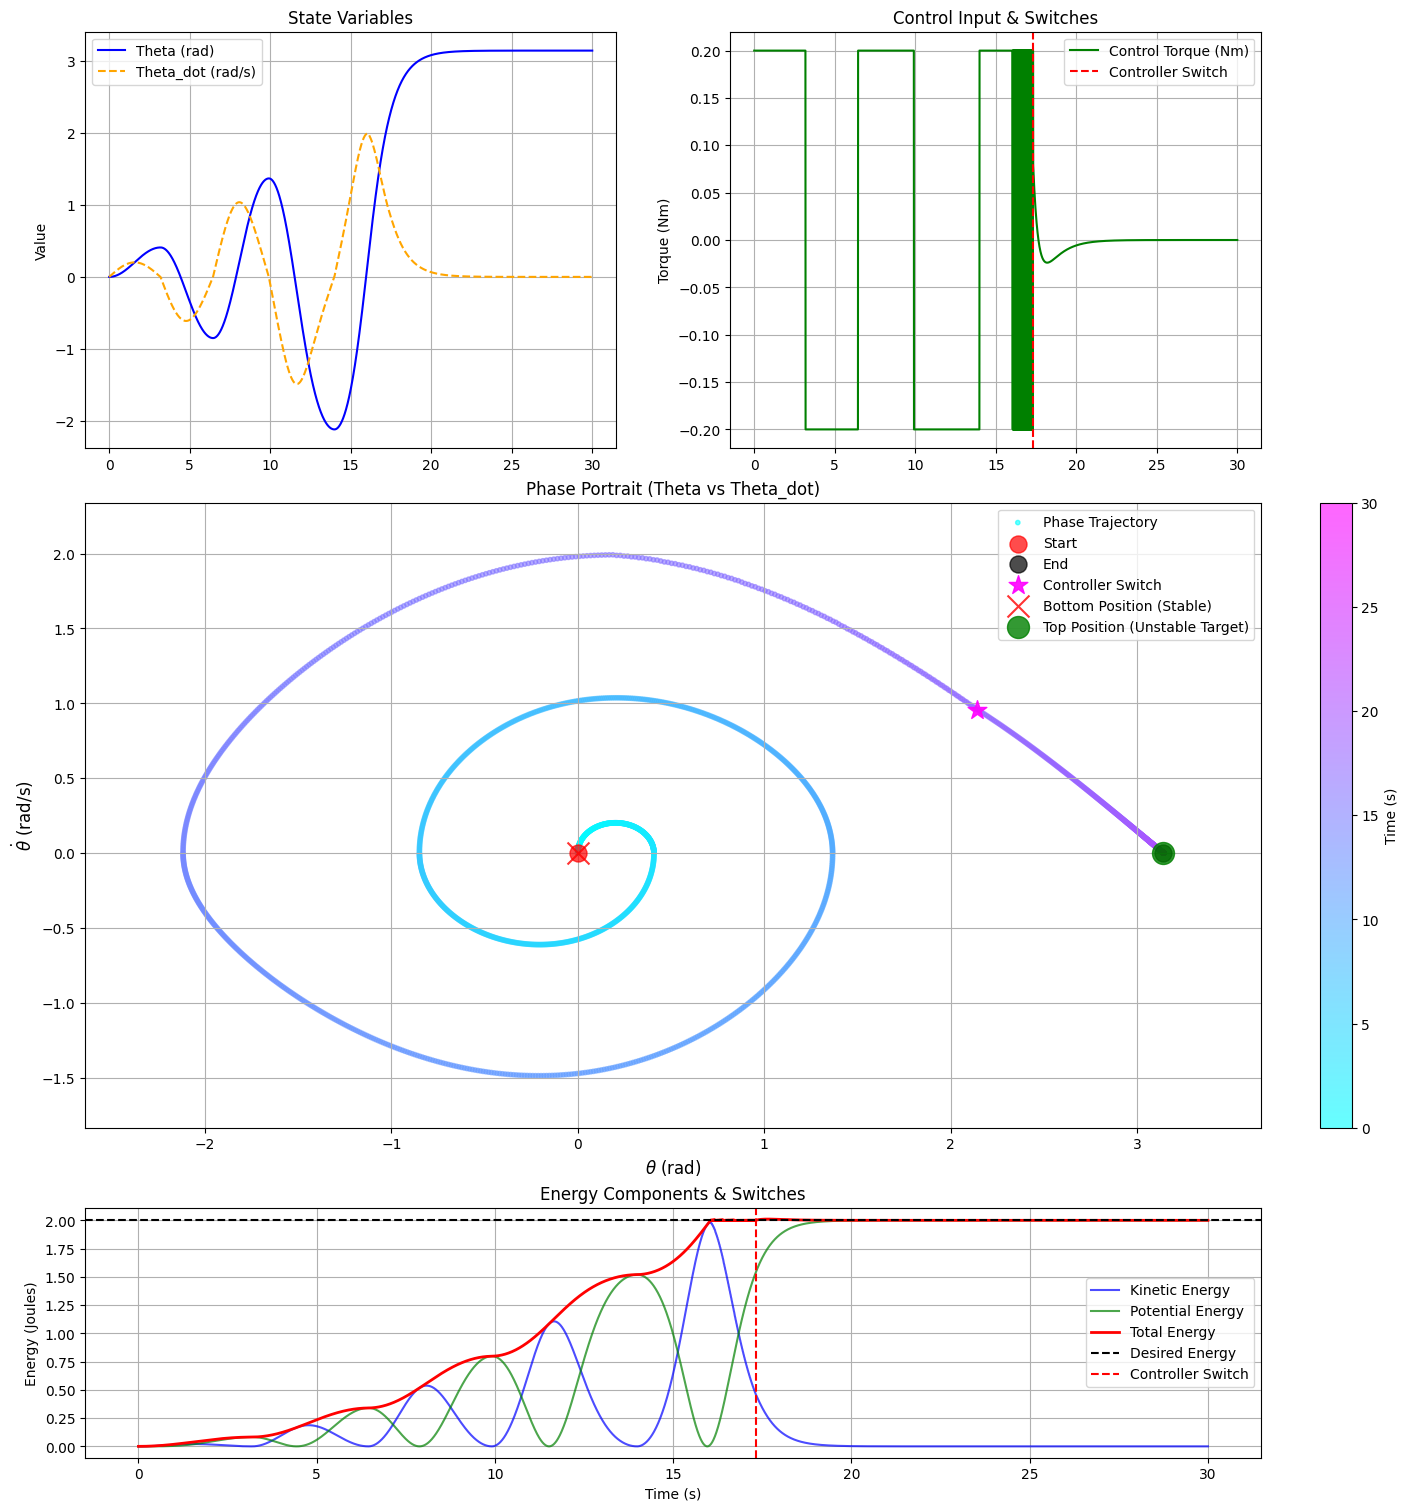

In [15]:
# --- 1. System Parameters ---
mass = 1.0  # kg
length = 1.0 # m
damping = 0.0 # Nms/rad
gravity = 1 # m/s^2 (Using standard gravity now)

# --- 2. Controller Parameters ---
max_tau = .2 # Nm (Max torque for energy control and saturation)

# PD Controller Gains (Tune these!)
# K_p = 15.0 # Example from previous script
# K_d = 2.0  # Example from previous script
# Using values from upper.ipynb for consistency check:
K_p = -2.0 # From upper.ipynb
K_d = -2.0 # From upper.ipynb

target_state_pd = np.array([np.pi, 0.0]) # Target: Upper equilibrium

# Switching thresholds (using defaults from EnergyPDController)
eps_theta_switch_val = 1
eps_E_switch_factor_val = 0.1

print("Parameters defined.")

# --- 3. Create System and Controller Instances ---
# Create Pendulum instance (will set initial state before simulation)
pendulum = Pendulum(mass=mass, length=length, damping=damping, gravity=gravity)

# Create individual controllers
energy_ctrl = EnergyControl(max_torque=max_tau)
pd_ctrl = LinearFeedbackController(K1=K_p, K2=K_d, target_state=target_state_pd)

# Create the combined controller
combined_ctrl = EnergyPDController(
    energy_controller=energy_ctrl,
    linear_controller=pd_ctrl,
    eps_theta_switch=eps_theta_switch_val,
    eps_E_switch_factor=eps_E_switch_factor_val
)
print("System and controller instances created.")

# --- 4. Simulation Setup ---
# Initial state [theta_0, theta_dot_0] (start at the bottom)
initial_state = np.array([0.0, 0.0])
# Set the initial state in the pendulum object *before* creating Simulation
pendulum.set_state(initial_state.copy())

# Simulation time
t_start = 0.0
t_end = 30.0 # Increased simulation time to see stabilization
dt = 0.01   # Simulation time step (increased slightly)
num_steps = int(t_end / dt)

print(f"Simulation setup: t_end={t_end}s, dt={dt}s, num_steps={num_steps}")

# --- 5. Create and Run Simulation ---
# Create the Simulation instance
sim = Simulation(
    system=pendulum,
    controller=combined_ctrl,
    dt=dt,
    num_steps=num_steps
)

combined_ctrl.reset()

sim.run()
sim.plot_results()


Запуск 12 симуляций...


Построение фазового портрета...
Plotting 100 trajectories...


<Figure size 1400x1000 with 0 Axes>

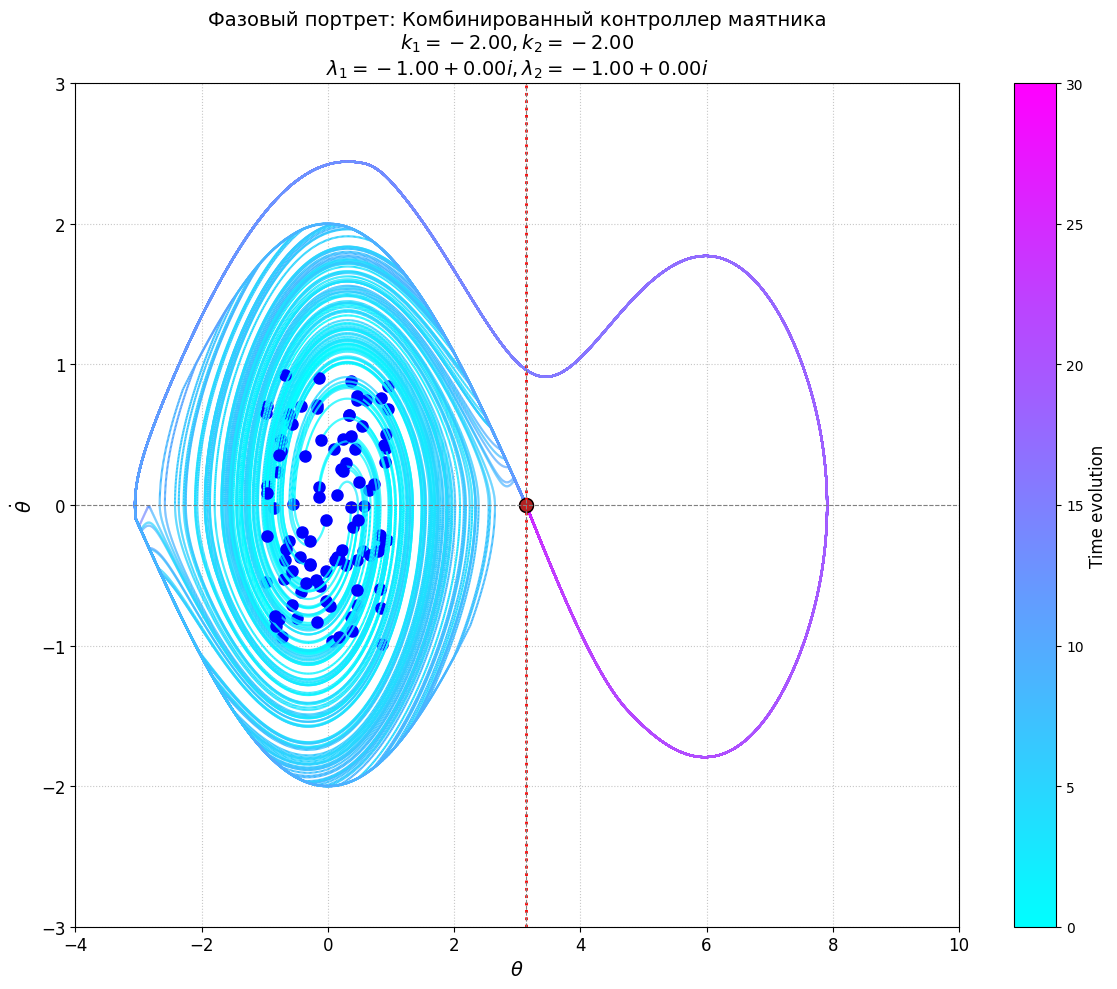

Симуляции завершены.


In [21]:


# --- Настройка множественных симуляций ---
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import importlib 



# --- Параметры системы ---
mass = 1.0       # кг
length = 1.0     # м
damping = 0   # Nms/rad
gravity = 1.0    # м/с^2

# --- Параметры контроллера ---
max_tau = 0.3    # Нм (максимальный момент)
K_p = -2.0       # Коэффициент усиления по позиции
K_d = -2.0       # Коэффициент усиления по скорости
target_state_pd = np.array([np.pi, 0.0])  # Верхняя точка равновесия

# Параметры переключения
eps_theta_switch_val = 0.1
eps_E_switch_factor_val = 0.01

# --- Параметры симуляции ---
t_end = 30.0  # с
dt = 0.01     # с
num_steps = int(t_end / dt)

# --- Создание различных начальных условий ---
# Создаем набор начальных состояний с разными углами и скоростями
theta_range = np.linspace(-0.5, 0.5, 4)  # диапазон начальных углов относительно нижней точки
theta_dot_range = np.linspace(-1.0, 1.0, 3)  # диапазон начальных скоростей

# Список для хранения результатов симуляций
simulation_results = []

# Создаем базовые объекты маятника и контроллеров
pendulum = Pendulum(mass=mass, length=length, damping=damping, gravity=gravity)
energy_ctrl = EnergyControl(max_torque=max_tau)
pd_ctrl = LinearFeedbackController(K1=K_p, K2=K_d, target_state=target_state_pd)

# Создаем комбинированный контроллер
combined_ctrl = EnergyPDController(
    energy_controller=energy_ctrl,
    linear_controller=pd_ctrl,
    eps_theta_switch=eps_theta_switch_val,
    eps_E_switch_factor=eps_E_switch_factor_val
)

print(f"Запуск {len(theta_range) * len(theta_dot_range)} симуляций...")

# --- Запуск множественных симуляций с разными начальными условиями ---
radius = 1
num_samples = 100
for theta_0, theta_dot_0 in np.random.uniform(low=-radius, high=radius, size=(num_samples, 2)):
        # Сбрасываем контроллер для каждой симуляции
        combined_ctrl.reset()
        
        # Устанавливаем начальное состояние
        initial_state = np.array([theta_0, theta_dot_0])
        pendulum.set_state(initial_state.copy())
        
        # Создаем и запускаем симуляцию
        sim = Simulation(
            system=pendulum,
            controller=combined_ctrl,
            dt=dt,
            num_steps=num_steps
        )
        
        sim.run()
        
        # Получаем результаты
        time_hist, state_hist, _ = sim.get_results()
        
        # Добавляем результаты в список
        simulation_results.append((time_hist, state_hist))
        
        # print(f"Симуляция с начальным состоянием {initial_state} завершена")


# --- Построение фазового портрета ---
print("Построение фазового портрета...")
plotter = Plotter(time_vector=None, state_history=None, control_history=None, system=None)

# Определяем центр фазового портрета и диапазон отображения
equilibrium_point = np.array([np.pi, 0.0])  # Верхняя точка равновесия
plot_range = (
    -4, 10.0,  # Увеличен диапазон theta до 4.0
    -3.0, 3.0   # Диапазон theta_dot от -3 до 3
)

# Рассчитываем собственные значения для заголовка
A_matrix = np.array([
    [0, 1],
    [gravity/length + K_p/(mass*length**2), K_d/(mass*length**2)]
])
eigenvalues = np.linalg.eigvals(A_matrix)

# Установка большего размера фигуры
plt.figure(figsize=(14, 10))

# Строим фазовый портрет
ax = plotter.plot_multiple_phase_portraits(
    simulation_results_list=simulation_results,
    equilibrium_point=equilibrium_point,
    k_coeffs=(K_p, K_d),
    eigenvalues=tuple(eigenvalues),
    title="Фазовый портрет: Комбинированный контроллер маятника",
    plot_range=plot_range
)

# Настройка параметров отображения для лучшей видимости
plt.tight_layout()

# Сохранение изображения высокого качества (опционально)
plt.savefig('img/phase_portrait_full.png', dpi=300, bbox_inches='tight')

# Отобразим график
plt.show()

print("Симуляции завершены.")